In [2]:
from main import main
main()

Training on 3330 images (Cardiomegaly)


Training Loss: 0.4219546616077423: 100%|██████| 209/209 [00:14<00:00, 14.00it/s]


Epoch: 1 | Training Loss: 0.62


Validation Loss: 0.3980768620967865: 100%|████| 104/104 [00:06<00:00, 15.54it/s]


Epoch: 1 | Validation Loss: 0.25


Training Loss: 0.4898515045642853: 100%|██████| 209/209 [00:13<00:00, 15.84it/s]


Epoch: 2 | Training Loss: 0.49


Validation Loss: 0.5116140246391296: 100%|████| 104/104 [00:06<00:00, 15.38it/s]


Epoch: 2 | Validation Loss: 0.24


Training Loss: 0.05027417093515396: 100%|█████| 209/209 [00:13<00:00, 15.85it/s]


Epoch: 3 | Training Loss: 0.43


Validation Loss: 0.29430726170539856: 100%|███| 104/104 [00:06<00:00, 15.21it/s]


Epoch: 3 | Validation Loss: 0.22


Training Loss: 0.6910812258720398: 100%|██████| 209/209 [00:13<00:00, 15.92it/s]


Epoch: 4 | Training Loss: 0.39


Validation Loss: 0.2633395195007324: 100%|████| 104/104 [00:06<00:00, 15.68it/s]


Epoch: 4 | Validation Loss: 0.22


Training Loss: 0.11212543398141861: 100%|█████| 209/209 [00:13<00:00, 15.74it/s]


Epoch: 5 | Training Loss: 0.35


Validation Loss: 0.48473572731018066: 100%|███| 104/104 [00:06<00:00, 15.46it/s]


Epoch: 5 | Validation Loss: 0.20


Training Loss: 0.2735959589481354: 100%|██████| 209/209 [00:13<00:00, 15.95it/s]


Epoch: 6 | Training Loss: 0.35


Validation Loss: 0.41258880496025085: 100%|███| 104/104 [00:06<00:00, 15.53it/s]


Epoch: 6 | Validation Loss: 0.22


Training Loss: 0.2803199887275696:  32%|██▏    | 66/209 [00:04<00:09, 14.31it/s]


KeyboardInterrupt: 

In [3]:
from dataset import ChestXray14
from model import get_encoder
import tqdm
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.spatial.distance import cdist
import random
from einops import rearrange, repeat
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition, mark_inset
from medcam import medcam

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

NameError: name 'retrieval_tasks' is not defined

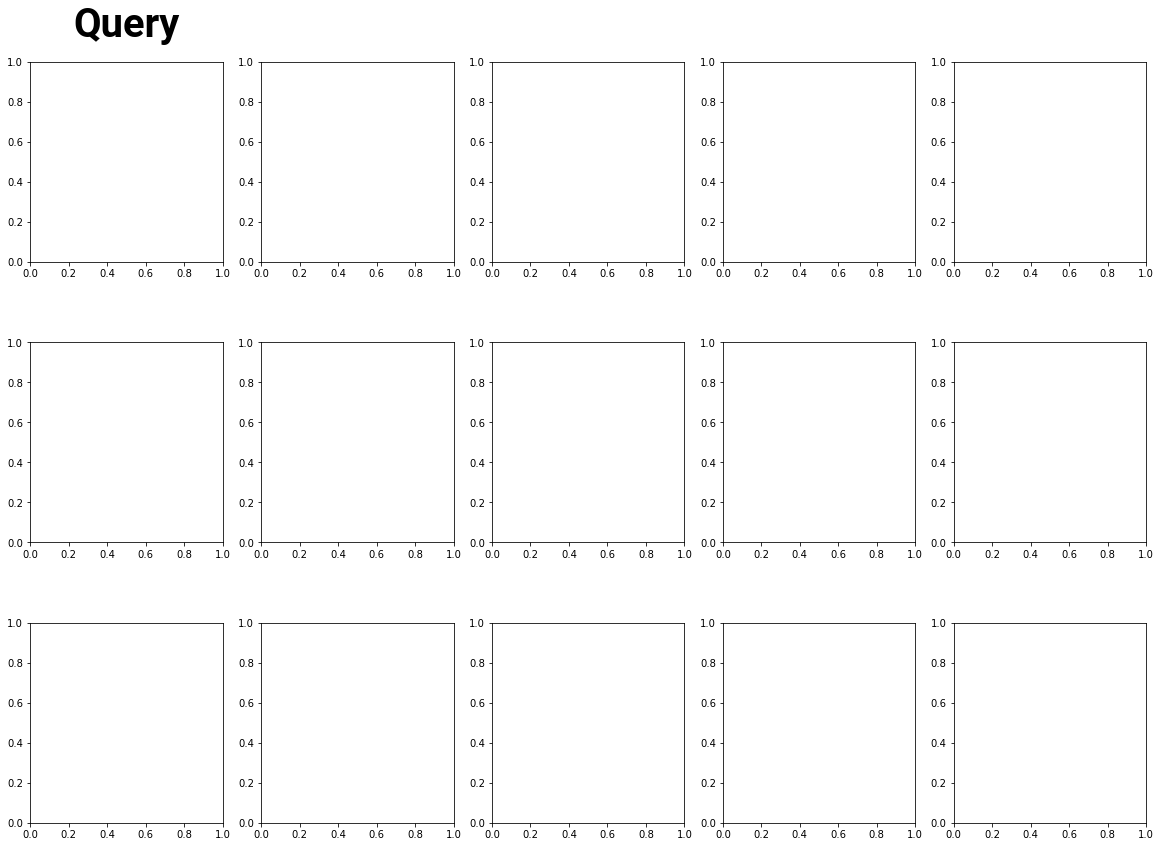

In [5]:
fig, ax = plt.subplots(3, 5, figsize=(20, 14))

path = 'fonts/Roboto-Bold.ttf'
fontprop = fm.FontProperties(fname=path, size=40)
title1 = ax[0][0].set_title('Query', fontproperties=fontprop, pad=25)

plt.subplots_adjust(hspace=0.4)

retrieval_indices = [481, 2722, 133]

for task_index, task in enumerate(retrieval_tasks):
    i = retrieval_indices[task_index]
    nearest_neighbor_indices = cdist(embeddings[task], embeddings[task])[i].argsort()
    nearest_neighbor_indices = nearest_neighbor_indices[nearest_neighbor_indices != i]
    indices = [i]
    indices.extend(nearest_neighbor_indices[:4])

    for image_index, sub_ax in enumerate(ax[task_index]):
        sub_ax.get_xaxis().set_ticks([])
        sub_ax.get_yaxis().set_ticks([])
        for spine in sub_ax.spines:
            sub_ax.spines[spine].set_visible(False)
        path = 'fonts/Roboto-Regular.ttf'
        fontprop = fm.FontProperties(fname=path, size=25)
        image = rearrange(images[task][indices[image_index]], 'c w h -> w h c')
        sub_ax.imshow(image, cmap='Greys_r')
        label = labels[task][indices[image_index]]
        if label:
            label = task
        else:
            label = 'No Finding'
        sub_ax.text(0.5, -0.1, label, ha='center', va='top',
               transform=sub_ax.transAxes, fontproperties=fontprop)

plt.savefig('figures/query.png', bbox_inches='tight')

## **Metrics**

In [6]:
embeddings = embeddings['Cardiomegaly']
labels = labels['Cardiomegaly']
images = images['Cardiomegaly']

NameError: name 'embeddings' is not defined

In [ ]:
def precision_at(k, i):
    nearest_neighbor_indices = cdist(embeddings, embeddings)[i].argsort()
    nearest_neighbor_indices = nearest_neighbor_indices[nearest_neighbor_indices != i]
    indices = []
    indices.extend(nearest_neighbor_indices[:k])
    return sum(labels[indices] == labels[i]) / k

p_at_5 = 0

for i in range(len(embeddings)):
    p_at_5 += precision_at(k=5, i=i)
    
print('ViT: ', p_at_5 / len(embeddings))

/home/developer/anaconda3/envs/cbir/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/developer/anaconda3/envs/cbir/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


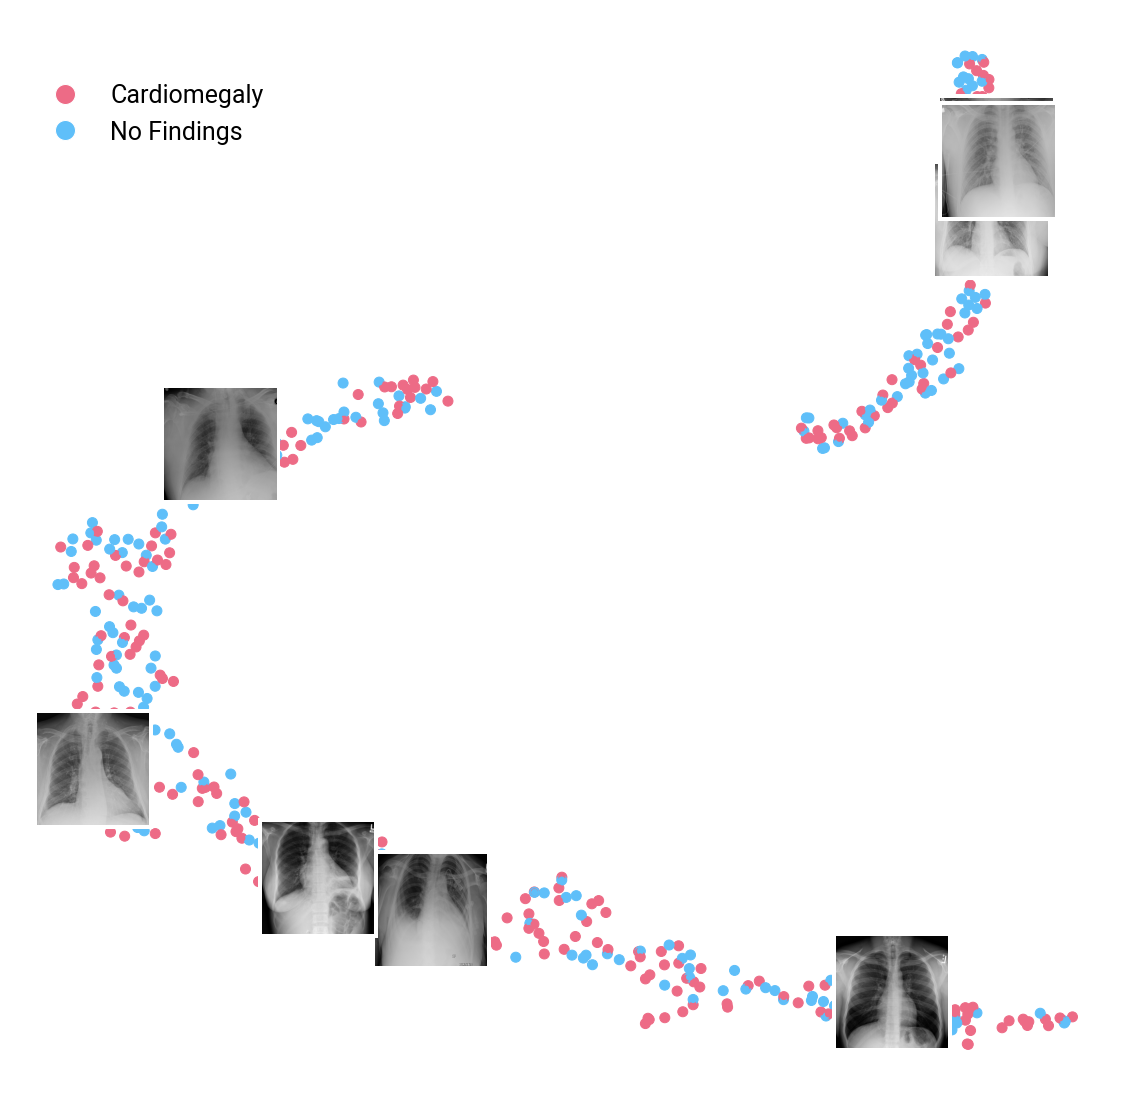

In [34]:
from sklearn.manifold import TSNE

z = TSNE().fit_transform(embeddings)

x, y = z[:, 0], z[:, 1]
x = (x - np.min(x)) / (np.max(x) - np.min(x))
y = (y - np.min(y)) / (np.max(y) - np.min(y))

positive_color = '#ED6B86'
negative_color = '#5FBFF9'

colors = [positive_color if labels[i] else negative_color for i in range(len(embeddings))]

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(x, y, color=colors, s=100)

for i in [180, 179, 177, 176, 347, 342, 340, 339]:  
    img = rearrange(images[i], 'c w h -> w h c')
    imgbox = OffsetImage(img, zoom=0.5, cmap='Greys_r')
    ab = AnnotationBbox(imgbox, (x[i], y[i]),
                    xycoords='data', boxcoords='offset points', bboxprops=dict(linewidth=0))
    ax.add_artist(ab)    

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for spine in ax.spines:
    ax.spines[spine].set_visible(False)


plt.scatter(x, y, color=colors)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D


path = 'fonts/Roboto-Regular.ttf'
fontprop = fm.FontProperties(fname=path, size=25)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Cardiomegaly', markerfacecolor=positive_color, markersize=20),
    Line2D([0], [0], marker='o', color='w', label='No Findings',markerfacecolor=negative_color, markersize=20)
]

lgnd = ax.legend(handles=legend_elements, bbox_to_anchor=(0.25, 0.95), frameon=False, prop=fontprop)
plt.savefig('figures/tsne.png', bbox_inches='tight')

In [4]:
retrieval_tasks = [
    'Cardiomegaly',
    'Opacity',
    'Emphysema',
]

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(20, 14))

path = 'fonts/Roboto-Bold.ttf'
fontprop = fm.FontProperties(fname=path, size=40)
title1 = ax[0][0].set_title('Query', fontproperties=fontprop, pad=25)

plt.subplots_adjust(hspace=0.4)

retrieval_indices = [481, 2722, 133]

for task_index, task in enumerate(retrieval_tasks):
    i = retrieval_indices[task_index]
    nearest_neighbor_indices = cdist(embeddings[task], embeddings[task])[i].argsort()
    nearest_neighbor_indices = nearest_neighbor_indices[nearest_neighbor_indices != i]
    indices = [i]
    indices.extend(nearest_neighbor_indices[:4])

    for image_index, sub_ax in enumerate(ax[task_index]):
        sub_ax.get_xaxis().set_ticks([])
        sub_ax.get_yaxis().set_ticks([])
        for spine in sub_ax.spines:
            sub_ax.spines[spine].set_visible(False)
        path = 'fonts/Roboto-Regular.ttf'
        fontprop = fm.FontProperties(fname=path, size=25)
        image = rearrange(images[task][indices[image_index]], 'c w h -> w h c')
        sub_ax.imshow(image, cmap='Greys_r')
        label = labels[task][indices[image_index]]
        if label:
            label = task
        else:
            label = 'No Finding'
        sub_ax.text(0.5, -0.1, label, ha='center', va='top',
               transform=sub_ax.transAxes, fontproperties=fontprop)

plt.savefig('figures/query.png', bbox_inches='tight')

## **Metrics**

In [30]:
embeddings = embeddings['Cardiomegaly']
labels = labels['Cardiomegaly']
images = images['Cardiomegaly']

In [ ]:
def precision_at(k, i):
    nearest_neighbor_indices = cdist(embeddings, embeddings)[i].argsort()
    nearest_neighbor_indices = nearest_neighbor_indices[nearest_neighbor_indices != i]
    indices = []
    indices.extend(nearest_neighbor_indices[:k])
    return sum(labels[indices] == labels[i]) / k

p_at_5 = 0

for i in range(len(embeddings)):
    p_at_5 += precision_at(k=5, i=i)
    
print('ViT: ', p_at_5 / len(embeddings))

/home/developer/anaconda3/envs/cbir/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/developer/anaconda3/envs/cbir/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


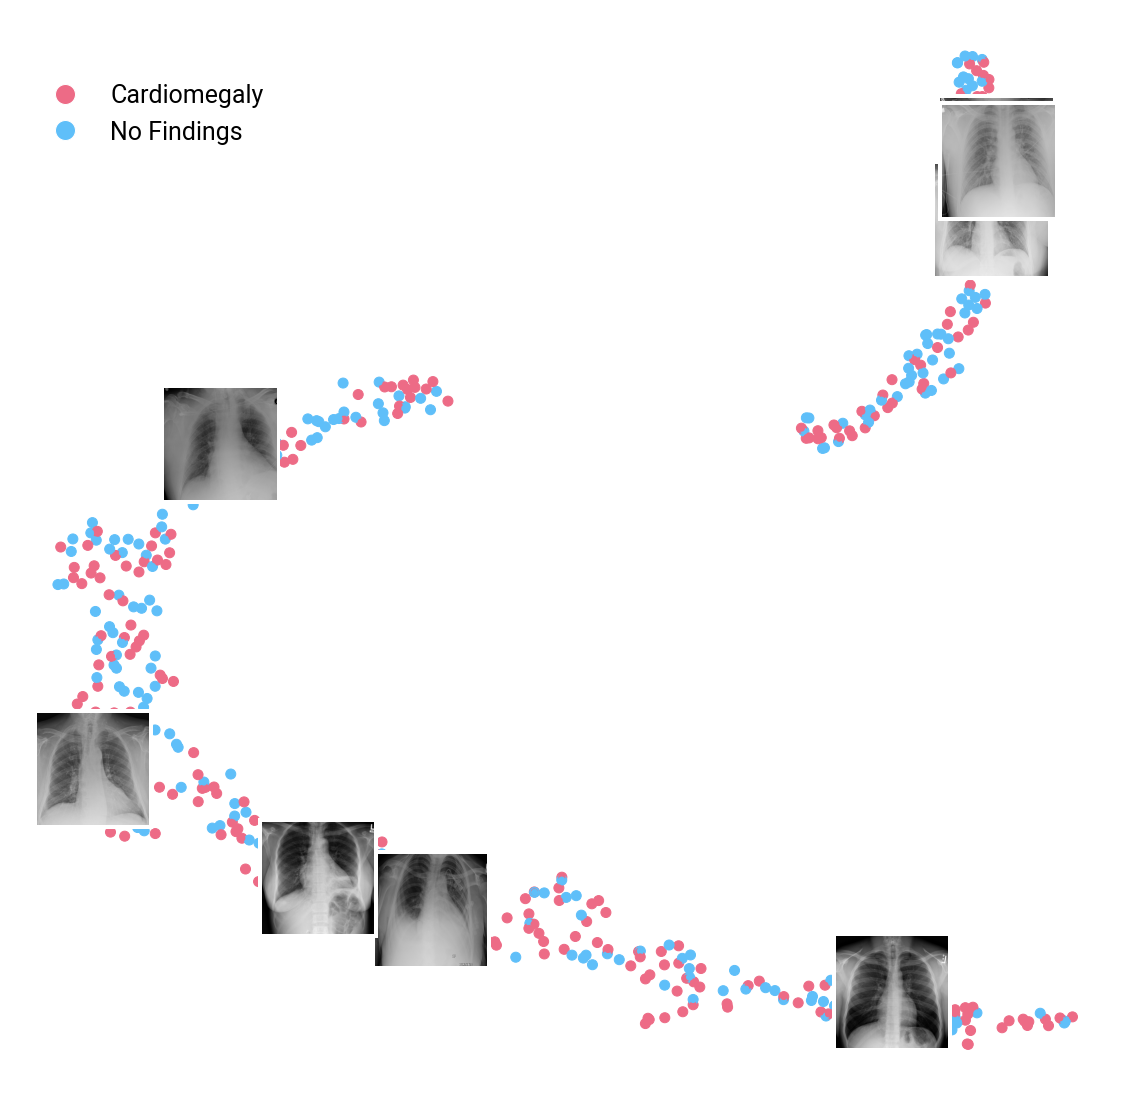

In [34]:
from sklearn.manifold import TSNE

z = TSNE().fit_transform(embeddings)

x, y = z[:, 0], z[:, 1]
x = (x - np.min(x)) / (np.max(x) - np.min(x))
y = (y - np.min(y)) / (np.max(y) - np.min(y))

positive_color = '#ED6B86'
negative_color = '#5FBFF9'

colors = [positive_color if labels[i] else negative_color for i in range(len(embeddings))]

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(x, y, color=colors, s=100)

for i in [180, 179, 177, 176, 347, 342, 340, 339]:  
    img = rearrange(images[i], 'c w h -> w h c')
    imgbox = OffsetImage(img, zoom=0.5, cmap='Greys_r')
    ab = AnnotationBbox(imgbox, (x[i], y[i]),
                    xycoords='data', boxcoords='offset points', bboxprops=dict(linewidth=0))
    ax.add_artist(ab)    

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for spine in ax.spines:
    ax.spines[spine].set_visible(False)


plt.scatter(x, y, color=colors)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D


path = 'fonts/Roboto-Regular.ttf'
fontprop = fm.FontProperties(fname=path, size=25)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Cardiomegaly', markerfacecolor=positive_color, markersize=20),
    Line2D([0], [0], marker='o', color='w', label='No Findings',markerfacecolor=negative_color, markersize=20)
]

lgnd = ax.legend(handles=legend_elements, bbox_to_anchor=(0.25, 0.95), frameon=False, prop=fontprop)
plt.savefig('figures/tsne.png', bbox_inches='tight')

In [5]:
def data(encoder_choice, class_name):
    model_weights_path = 'weights/{}_{}_weights'.format(encoder_choice, class_name)
    model = get_encoder(encoder_choice=encoder_choice)
    model = model.to(device)
    model.load_state_dict(torch.load(model_weights_path))
    model.eval()
    images = []
    embeddings = []
    labels = []
    test_dataset = ChestXray14(phase='test', class_name=class_name)
    test_data_loader = DataLoader(test_dataset, shuffle=False)
    progress_bar = tqdm.tqdm(test_data_loader)
    progress_bar.set_description(class_name)
    for data in progress_bar:
        image, label = data
        image, label = image.to(device), label.to(device)        
        embedding = model(image)
        image = image.cpu().detach().numpy()[0]
        embedding = embedding.cpu().detach().numpy()[0]
        label = label.cpu().detach().numpy()[0]
        images.append(image)
        embeddings.append(embedding)
        labels.append(label)

    images = np.array(images)
    embeddings = np.array(embeddings)
    labels = np.array(labels)
    return images, embeddings, labels

images = {}
embeddings = {}
labels = {}

for task in retrieval_tasks:
    encoder_choice = 'vit'
    class_name = task
    images[task], embeddings[task], labels[task] = data(encoder_choice, class_name)

Using cache found in /home/developer/.cache/torch/hub/facebookresearch_deit_main
Cardiomegaly: 100%|███████████████████████████| 556/556 [00:11<00:00, 47.20it/s]
Using cache found in /home/developer/.cache/torch/hub/facebookresearch_deit_main


RuntimeError: Error(s) in loading state_dict for VisionTransformer:
	Missing key(s) in state_dict: "cls_token", "pos_embed", "patch_embed.proj.weight", "patch_embed.proj.bias", "blocks.0.norm1.weight", "blocks.0.norm1.bias", "blocks.0.attn.qkv.weight", "blocks.0.attn.qkv.bias", "blocks.0.attn.proj.weight", "blocks.0.attn.proj.bias", "blocks.0.norm2.weight", "blocks.0.norm2.bias", "blocks.0.mlp.fc1.weight", "blocks.0.mlp.fc1.bias", "blocks.0.mlp.fc2.weight", "blocks.0.mlp.fc2.bias", "blocks.1.norm1.weight", "blocks.1.norm1.bias", "blocks.1.attn.qkv.weight", "blocks.1.attn.qkv.bias", "blocks.1.attn.proj.weight", "blocks.1.attn.proj.bias", "blocks.1.norm2.weight", "blocks.1.norm2.bias", "blocks.1.mlp.fc1.weight", "blocks.1.mlp.fc1.bias", "blocks.1.mlp.fc2.weight", "blocks.1.mlp.fc2.bias", "blocks.2.norm1.weight", "blocks.2.norm1.bias", "blocks.2.attn.qkv.weight", "blocks.2.attn.qkv.bias", "blocks.2.attn.proj.weight", "blocks.2.attn.proj.bias", "blocks.2.norm2.weight", "blocks.2.norm2.bias", "blocks.2.mlp.fc1.weight", "blocks.2.mlp.fc1.bias", "blocks.2.mlp.fc2.weight", "blocks.2.mlp.fc2.bias", "blocks.3.norm1.weight", "blocks.3.norm1.bias", "blocks.3.attn.qkv.weight", "blocks.3.attn.qkv.bias", "blocks.3.attn.proj.weight", "blocks.3.attn.proj.bias", "blocks.3.norm2.weight", "blocks.3.norm2.bias", "blocks.3.mlp.fc1.weight", "blocks.3.mlp.fc1.bias", "blocks.3.mlp.fc2.weight", "blocks.3.mlp.fc2.bias", "blocks.4.norm1.weight", "blocks.4.norm1.bias", "blocks.4.attn.qkv.weight", "blocks.4.attn.qkv.bias", "blocks.4.attn.proj.weight", "blocks.4.attn.proj.bias", "blocks.4.norm2.weight", "blocks.4.norm2.bias", "blocks.4.mlp.fc1.weight", "blocks.4.mlp.fc1.bias", "blocks.4.mlp.fc2.weight", "blocks.4.mlp.fc2.bias", "blocks.5.norm1.weight", "blocks.5.norm1.bias", "blocks.5.attn.qkv.weight", "blocks.5.attn.qkv.bias", "blocks.5.attn.proj.weight", "blocks.5.attn.proj.bias", "blocks.5.norm2.weight", "blocks.5.norm2.bias", "blocks.5.mlp.fc1.weight", "blocks.5.mlp.fc1.bias", "blocks.5.mlp.fc2.weight", "blocks.5.mlp.fc2.bias", "blocks.6.norm1.weight", "blocks.6.norm1.bias", "blocks.6.attn.qkv.weight", "blocks.6.attn.qkv.bias", "blocks.6.attn.proj.weight", "blocks.6.attn.proj.bias", "blocks.6.norm2.weight", "blocks.6.norm2.bias", "blocks.6.mlp.fc1.weight", "blocks.6.mlp.fc1.bias", "blocks.6.mlp.fc2.weight", "blocks.6.mlp.fc2.bias", "blocks.7.norm1.weight", "blocks.7.norm1.bias", "blocks.7.attn.qkv.weight", "blocks.7.attn.qkv.bias", "blocks.7.attn.proj.weight", "blocks.7.attn.proj.bias", "blocks.7.norm2.weight", "blocks.7.norm2.bias", "blocks.7.mlp.fc1.weight", "blocks.7.mlp.fc1.bias", "blocks.7.mlp.fc2.weight", "blocks.7.mlp.fc2.bias", "blocks.8.norm1.weight", "blocks.8.norm1.bias", "blocks.8.attn.qkv.weight", "blocks.8.attn.qkv.bias", "blocks.8.attn.proj.weight", "blocks.8.attn.proj.bias", "blocks.8.norm2.weight", "blocks.8.norm2.bias", "blocks.8.mlp.fc1.weight", "blocks.8.mlp.fc1.bias", "blocks.8.mlp.fc2.weight", "blocks.8.mlp.fc2.bias", "blocks.9.norm1.weight", "blocks.9.norm1.bias", "blocks.9.attn.qkv.weight", "blocks.9.attn.qkv.bias", "blocks.9.attn.proj.weight", "blocks.9.attn.proj.bias", "blocks.9.norm2.weight", "blocks.9.norm2.bias", "blocks.9.mlp.fc1.weight", "blocks.9.mlp.fc1.bias", "blocks.9.mlp.fc2.weight", "blocks.9.mlp.fc2.bias", "blocks.10.norm1.weight", "blocks.10.norm1.bias", "blocks.10.attn.qkv.weight", "blocks.10.attn.qkv.bias", "blocks.10.attn.proj.weight", "blocks.10.attn.proj.bias", "blocks.10.norm2.weight", "blocks.10.norm2.bias", "blocks.10.mlp.fc1.weight", "blocks.10.mlp.fc1.bias", "blocks.10.mlp.fc2.weight", "blocks.10.mlp.fc2.bias", "blocks.11.norm1.weight", "blocks.11.norm1.bias", "blocks.11.attn.qkv.weight", "blocks.11.attn.qkv.bias", "blocks.11.attn.proj.weight", "blocks.11.attn.proj.bias", "blocks.11.norm2.weight", "blocks.11.norm2.bias", "blocks.11.mlp.fc1.weight", "blocks.11.mlp.fc1.bias", "blocks.11.mlp.fc2.weight", "blocks.11.mlp.fc2.bias", "norm.weight", "norm.bias", "head.weight", "head.bias". 
	Unexpected key(s) in state_dict: "backbone.pos_embedding", "backbone.cls_token", "backbone.to_patch_embedding.1.weight", "backbone.to_patch_embedding.1.bias", "backbone.transformer.net.layers.0.0.fn.proj_k", "backbone.transformer.net.layers.0.0.fn.proj_v", "backbone.transformer.net.layers.0.0.fn.to_q.weight", "backbone.transformer.net.layers.0.0.fn.to_k.weight", "backbone.transformer.net.layers.0.0.fn.to_v.weight", "backbone.transformer.net.layers.0.0.fn.to_out.weight", "backbone.transformer.net.layers.0.0.fn.to_out.bias", "backbone.transformer.net.layers.0.0.norm.weight", "backbone.transformer.net.layers.0.0.norm.bias", "backbone.transformer.net.layers.0.1.fn.w1.weight", "backbone.transformer.net.layers.0.1.fn.w1.bias", "backbone.transformer.net.layers.0.1.fn.w2.weight", "backbone.transformer.net.layers.0.1.fn.w2.bias", "backbone.transformer.net.layers.0.1.norm.weight", "backbone.transformer.net.layers.0.1.norm.bias", "backbone.transformer.net.layers.1.0.fn.proj_k", "backbone.transformer.net.layers.1.0.fn.proj_v", "backbone.transformer.net.layers.1.0.fn.to_q.weight", "backbone.transformer.net.layers.1.0.fn.to_k.weight", "backbone.transformer.net.layers.1.0.fn.to_v.weight", "backbone.transformer.net.layers.1.0.fn.to_out.weight", "backbone.transformer.net.layers.1.0.fn.to_out.bias", "backbone.transformer.net.layers.1.0.norm.weight", "backbone.transformer.net.layers.1.0.norm.bias", "backbone.transformer.net.layers.1.1.fn.w1.weight", "backbone.transformer.net.layers.1.1.fn.w1.bias", "backbone.transformer.net.layers.1.1.fn.w2.weight", "backbone.transformer.net.layers.1.1.fn.w2.bias", "backbone.transformer.net.layers.1.1.norm.weight", "backbone.transformer.net.layers.1.1.norm.bias", "backbone.transformer.net.layers.2.0.fn.proj_k", "backbone.transformer.net.layers.2.0.fn.proj_v", "backbone.transformer.net.layers.2.0.fn.to_q.weight", "backbone.transformer.net.layers.2.0.fn.to_k.weight", "backbone.transformer.net.layers.2.0.fn.to_v.weight", "backbone.transformer.net.layers.2.0.fn.to_out.weight", "backbone.transformer.net.layers.2.0.fn.to_out.bias", "backbone.transformer.net.layers.2.0.norm.weight", "backbone.transformer.net.layers.2.0.norm.bias", "backbone.transformer.net.layers.2.1.fn.w1.weight", "backbone.transformer.net.layers.2.1.fn.w1.bias", "backbone.transformer.net.layers.2.1.fn.w2.weight", "backbone.transformer.net.layers.2.1.fn.w2.bias", "backbone.transformer.net.layers.2.1.norm.weight", "backbone.transformer.net.layers.2.1.norm.bias", "backbone.transformer.net.layers.3.0.fn.proj_k", "backbone.transformer.net.layers.3.0.fn.proj_v", "backbone.transformer.net.layers.3.0.fn.to_q.weight", "backbone.transformer.net.layers.3.0.fn.to_k.weight", "backbone.transformer.net.layers.3.0.fn.to_v.weight", "backbone.transformer.net.layers.3.0.fn.to_out.weight", "backbone.transformer.net.layers.3.0.fn.to_out.bias", "backbone.transformer.net.layers.3.0.norm.weight", "backbone.transformer.net.layers.3.0.norm.bias", "backbone.transformer.net.layers.3.1.fn.w1.weight", "backbone.transformer.net.layers.3.1.fn.w1.bias", "backbone.transformer.net.layers.3.1.fn.w2.weight", "backbone.transformer.net.layers.3.1.fn.w2.bias", "backbone.transformer.net.layers.3.1.norm.weight", "backbone.transformer.net.layers.3.1.norm.bias", "backbone.transformer.net.layers.4.0.fn.proj_k", "backbone.transformer.net.layers.4.0.fn.proj_v", "backbone.transformer.net.layers.4.0.fn.to_q.weight", "backbone.transformer.net.layers.4.0.fn.to_k.weight", "backbone.transformer.net.layers.4.0.fn.to_v.weight", "backbone.transformer.net.layers.4.0.fn.to_out.weight", "backbone.transformer.net.layers.4.0.fn.to_out.bias", "backbone.transformer.net.layers.4.0.norm.weight", "backbone.transformer.net.layers.4.0.norm.bias", "backbone.transformer.net.layers.4.1.fn.w1.weight", "backbone.transformer.net.layers.4.1.fn.w1.bias", "backbone.transformer.net.layers.4.1.fn.w2.weight", "backbone.transformer.net.layers.4.1.fn.w2.bias", "backbone.transformer.net.layers.4.1.norm.weight", "backbone.transformer.net.layers.4.1.norm.bias", "backbone.transformer.net.layers.5.0.fn.proj_k", "backbone.transformer.net.layers.5.0.fn.proj_v", "backbone.transformer.net.layers.5.0.fn.to_q.weight", "backbone.transformer.net.layers.5.0.fn.to_k.weight", "backbone.transformer.net.layers.5.0.fn.to_v.weight", "backbone.transformer.net.layers.5.0.fn.to_out.weight", "backbone.transformer.net.layers.5.0.fn.to_out.bias", "backbone.transformer.net.layers.5.0.norm.weight", "backbone.transformer.net.layers.5.0.norm.bias", "backbone.transformer.net.layers.5.1.fn.w1.weight", "backbone.transformer.net.layers.5.1.fn.w1.bias", "backbone.transformer.net.layers.5.1.fn.w2.weight", "backbone.transformer.net.layers.5.1.fn.w2.bias", "backbone.transformer.net.layers.5.1.norm.weight", "backbone.transformer.net.layers.5.1.norm.bias", "backbone.transformer.net.layers.6.0.fn.proj_k", "backbone.transformer.net.layers.6.0.fn.proj_v", "backbone.transformer.net.layers.6.0.fn.to_q.weight", "backbone.transformer.net.layers.6.0.fn.to_k.weight", "backbone.transformer.net.layers.6.0.fn.to_v.weight", "backbone.transformer.net.layers.6.0.fn.to_out.weight", "backbone.transformer.net.layers.6.0.fn.to_out.bias", "backbone.transformer.net.layers.6.0.norm.weight", "backbone.transformer.net.layers.6.0.norm.bias", "backbone.transformer.net.layers.6.1.fn.w1.weight", "backbone.transformer.net.layers.6.1.fn.w1.bias", "backbone.transformer.net.layers.6.1.fn.w2.weight", "backbone.transformer.net.layers.6.1.fn.w2.bias", "backbone.transformer.net.layers.6.1.norm.weight", "backbone.transformer.net.layers.6.1.norm.bias", "backbone.transformer.net.layers.7.0.fn.proj_k", "backbone.transformer.net.layers.7.0.fn.proj_v", "backbone.transformer.net.layers.7.0.fn.to_q.weight", "backbone.transformer.net.layers.7.0.fn.to_k.weight", "backbone.transformer.net.layers.7.0.fn.to_v.weight", "backbone.transformer.net.layers.7.0.fn.to_out.weight", "backbone.transformer.net.layers.7.0.fn.to_out.bias", "backbone.transformer.net.layers.7.0.norm.weight", "backbone.transformer.net.layers.7.0.norm.bias", "backbone.transformer.net.layers.7.1.fn.w1.weight", "backbone.transformer.net.layers.7.1.fn.w1.bias", "backbone.transformer.net.layers.7.1.fn.w2.weight", "backbone.transformer.net.layers.7.1.fn.w2.bias", "backbone.transformer.net.layers.7.1.norm.weight", "backbone.transformer.net.layers.7.1.norm.bias", "backbone.transformer.net.layers.8.0.fn.proj_k", "backbone.transformer.net.layers.8.0.fn.proj_v", "backbone.transformer.net.layers.8.0.fn.to_q.weight", "backbone.transformer.net.layers.8.0.fn.to_k.weight", "backbone.transformer.net.layers.8.0.fn.to_v.weight", "backbone.transformer.net.layers.8.0.fn.to_out.weight", "backbone.transformer.net.layers.8.0.fn.to_out.bias", "backbone.transformer.net.layers.8.0.norm.weight", "backbone.transformer.net.layers.8.0.norm.bias", "backbone.transformer.net.layers.8.1.fn.w1.weight", "backbone.transformer.net.layers.8.1.fn.w1.bias", "backbone.transformer.net.layers.8.1.fn.w2.weight", "backbone.transformer.net.layers.8.1.fn.w2.bias", "backbone.transformer.net.layers.8.1.norm.weight", "backbone.transformer.net.layers.8.1.norm.bias", "backbone.transformer.net.layers.9.0.fn.proj_k", "backbone.transformer.net.layers.9.0.fn.proj_v", "backbone.transformer.net.layers.9.0.fn.to_q.weight", "backbone.transformer.net.layers.9.0.fn.to_k.weight", "backbone.transformer.net.layers.9.0.fn.to_v.weight", "backbone.transformer.net.layers.9.0.fn.to_out.weight", "backbone.transformer.net.layers.9.0.fn.to_out.bias", "backbone.transformer.net.layers.9.0.norm.weight", "backbone.transformer.net.layers.9.0.norm.bias", "backbone.transformer.net.layers.9.1.fn.w1.weight", "backbone.transformer.net.layers.9.1.fn.w1.bias", "backbone.transformer.net.layers.9.1.fn.w2.weight", "backbone.transformer.net.layers.9.1.fn.w2.bias", "backbone.transformer.net.layers.9.1.norm.weight", "backbone.transformer.net.layers.9.1.norm.bias", "backbone.transformer.net.layers.10.0.fn.proj_k", "backbone.transformer.net.layers.10.0.fn.proj_v", "backbone.transformer.net.layers.10.0.fn.to_q.weight", "backbone.transformer.net.layers.10.0.fn.to_k.weight", "backbone.transformer.net.layers.10.0.fn.to_v.weight", "backbone.transformer.net.layers.10.0.fn.to_out.weight", "backbone.transformer.net.layers.10.0.fn.to_out.bias", "backbone.transformer.net.layers.10.0.norm.weight", "backbone.transformer.net.layers.10.0.norm.bias", "backbone.transformer.net.layers.10.1.fn.w1.weight", "backbone.transformer.net.layers.10.1.fn.w1.bias", "backbone.transformer.net.layers.10.1.fn.w2.weight", "backbone.transformer.net.layers.10.1.fn.w2.bias", "backbone.transformer.net.layers.10.1.norm.weight", "backbone.transformer.net.layers.10.1.norm.bias", "backbone.transformer.net.layers.11.0.fn.proj_k", "backbone.transformer.net.layers.11.0.fn.proj_v", "backbone.transformer.net.layers.11.0.fn.to_q.weight", "backbone.transformer.net.layers.11.0.fn.to_k.weight", "backbone.transformer.net.layers.11.0.fn.to_v.weight", "backbone.transformer.net.layers.11.0.fn.to_out.weight", "backbone.transformer.net.layers.11.0.fn.to_out.bias", "backbone.transformer.net.layers.11.0.norm.weight", "backbone.transformer.net.layers.11.0.norm.bias", "backbone.transformer.net.layers.11.1.fn.w1.weight", "backbone.transformer.net.layers.11.1.fn.w1.bias", "backbone.transformer.net.layers.11.1.fn.w2.weight", "backbone.transformer.net.layers.11.1.fn.w2.bias", "backbone.transformer.net.layers.11.1.norm.weight", "backbone.transformer.net.layers.11.1.norm.bias", "backbone.mlp_head.0.weight", "backbone.mlp_head.0.bias", "backbone.mlp_head.1.weight", "backbone.mlp_head.1.bias". 

In [10]:
embeddings = embeddings

array([[ 1.5127283 , -1.3617088 ],
       [-0.10774769,  0.39475614],
       [ 0.95370334, -0.6708515 ],
       ...,
       [ 0.81589913, -0.5252755 ],
       [ 1.3455323 , -1.0881984 ],
       [-0.7950605 ,  1.1462287 ]], dtype=float32)

In [13]:
labels = labels['Cardiomegaly']

In [14]:
def precision_at(k, i):
    nearest_neighbor_indices = cdist(embeddings, embeddings)[i].argsort()
    nearest_neighbor_indices = nearest_neighbor_indices[nearest_neighbor_indices != i]
    indices = []
    indices.extend(nearest_neighbor_indices[:k])
    return sum(labels[indices] == labels[i]) / k

p_at_5 = 0

for i in range(len(embeddings)):
    p_at_5 += precision_at(k=5, i=i)
    
print('Orig: ', p_at_5 / len(embeddings))

Orig:  0.6395683453237417


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

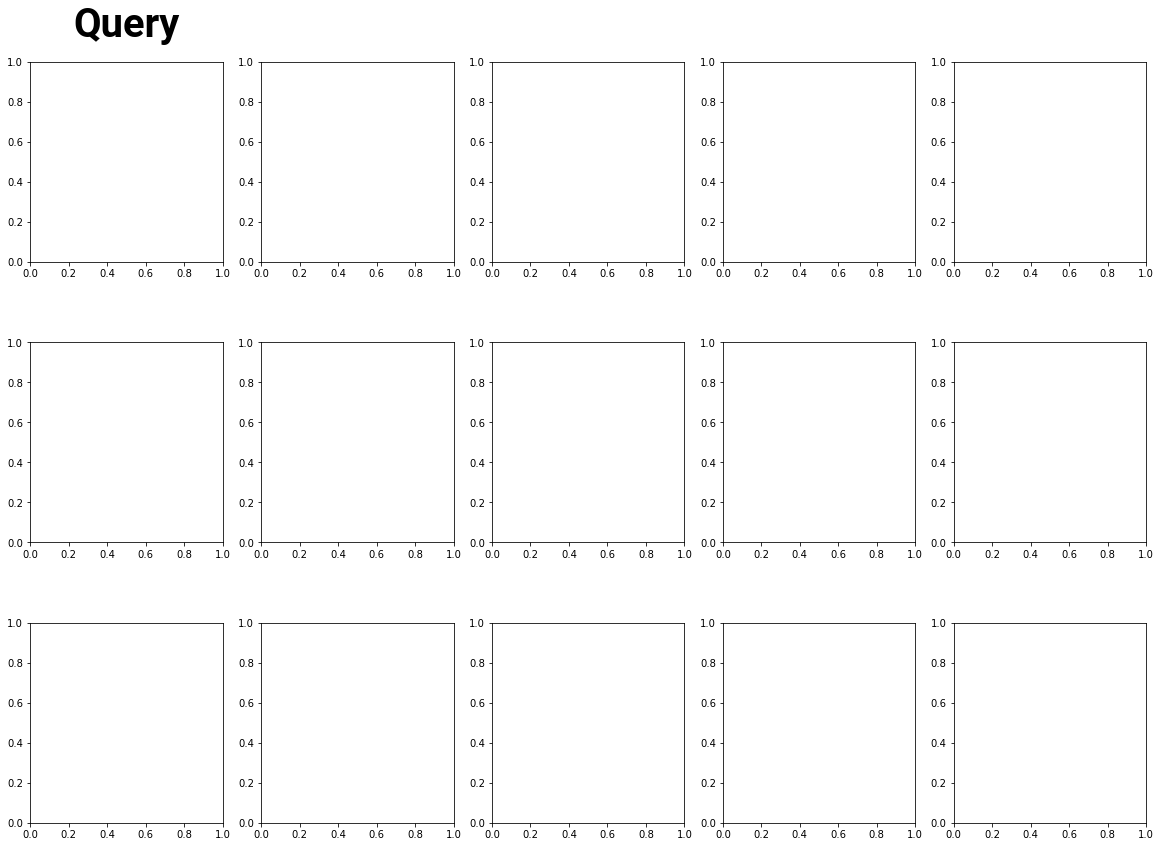

In [16]:
fig, ax = plt.subplots(3, 5, figsize=(20, 14))

path = 'fonts/Roboto-Bold.ttf'
fontprop = fm.FontProperties(fname=path, size=40)
title1 = ax[0][0].set_title('Query', fontproperties=fontprop, pad=25)

plt.subplots_adjust(hspace=0.4)

retrieval_indices = [481, 2722, 133]

for task_index, task in enumerate(retrieval_tasks):
    i = retrieval_indices[task_index]
    nearest_neighbor_indices = cdist(embeddings[task], embeddings[task])[i].argsort()
    nearest_neighbor_indices = nearest_neighbor_indices[nearest_neighbor_indices != i]
    indices = [i]
    indices.extend(nearest_neighbor_indices[:4])

    for image_index, sub_ax in enumerate(ax[task_index]):
        sub_ax.get_xaxis().set_ticks([])
        sub_ax.get_yaxis().set_ticks([])
        for spine in sub_ax.spines:
            sub_ax.spines[spine].set_visible(False)
        path = 'fonts/Roboto-Regular.ttf'
        fontprop = fm.FontProperties(fname=path, size=25)
        image = rearrange(images[task][indices[image_index]], 'c w h -> w h c')
        sub_ax.imshow(image, cmap='Greys_r')
        label = labels[task][indices[image_index]]
        if label:
            label = task
        else:
            label = 'No Finding'
        sub_ax.text(0.5, -0.1, label, ha='center', va='top',
               transform=sub_ax.transAxes, fontproperties=fontprop)

plt.savefig('figures/query.png', bbox_inches='tight')

KeyError: 180

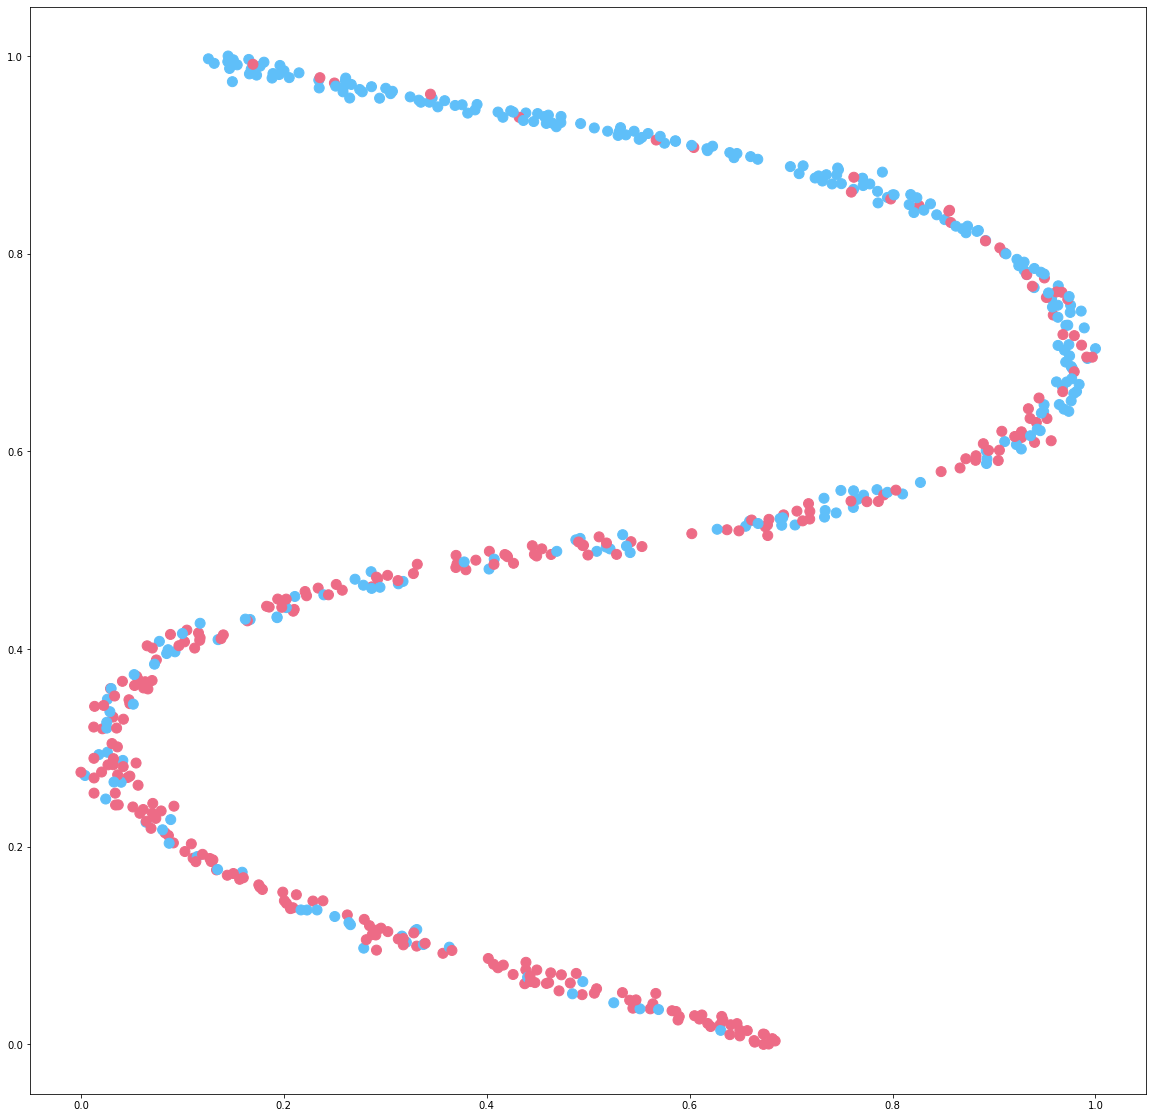

In [17]:
from sklearn.manifold import TSNE

z = TSNE().fit_transform(embeddings)

x, y = z[:, 0], z[:, 1]
x = (x - np.min(x)) / (np.max(x) - np.min(x))
y = (y - np.min(y)) / (np.max(y) - np.min(y))

positive_color = '#ED6B86'
negative_color = '#5FBFF9'

colors = [positive_color if labels[i] else negative_color for i in range(len(embeddings))]

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(x, y, color=colors, s=100)

for i in [180, 179, 177, 176, 347, 342, 340, 339]:  
    img = rearrange(images[i], 'c w h -> w h c')
    imgbox = OffsetImage(img, zoom=0.5, cmap='Greys_r')
    ab = AnnotationBbox(imgbox, (x[i], y[i]),
                    xycoords='data', boxcoords='offset points', bboxprops=dict(linewidth=0))
    ax.add_artist(ab)    

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for spine in ax.spines:
    ax.spines[spine].set_visible(False)


plt.scatter(x, y, color=colors)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D


path = 'fonts/Roboto-Regular.ttf'
fontprop = fm.FontProperties(fname=path, size=25)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Cardiomegaly', markerfacecolor=positive_color, markersize=20),
    Line2D([0], [0], marker='o', color='w', label='No Findings',markerfacecolor=negative_color, markersize=20)
]

lgnd = ax.legend(handles=legend_elements, bbox_to_anchor=(0.25, 0.95), frameon=False, prop=fontprop)
plt.savefig('figures/tsne.png', bbox_inches='tight')